# Integer Program For Evacuation With Vehicles And Stamina Ratings.
This script describes the distribution of miners between refuge chambers and shafts during a mine evacuation.
A CAD model from the Turqoise Ridge Mine (Nevada Gold Mines) was used for validating the model.
Vehicles are incorporated in this model, also, stamina ratings are applied for the miners at the time of evacuation.

***

## Import the required libraries.

In [1]:
import pandas as pd
import timeit
import math
import random
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

## Create a dataframe from the airlines(drifts) .xlsx file.
The .xlsx file was obtained by extracting the drift coordinates from the CAD file of the mine. The drifts are referred to as **'airlines'** in the CAD model.

In [2]:
drifts = pd.read_excel("airlines.xlsx")

## Visualize the layout of the TR Mine in 3-dimensions.
The mine has two shafts serving as the main source of egress. The mine extends multiple levels spanning several kilometers.

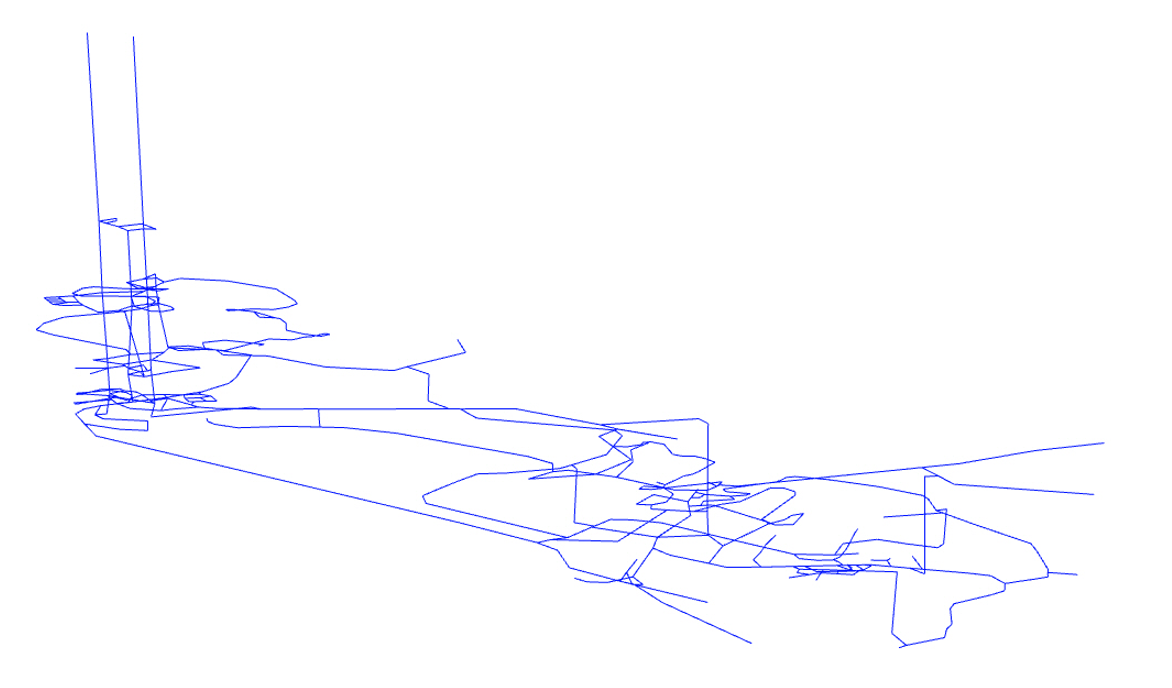

## Start the timer.
The timer is used to check the elapsed time from the creation of the model components to the final output.

In [3]:
start = timeit.default_timer()

## Extract the nodes within the mine network.
The drift nodes represent transhipment nodes. Other node types are specified later.

In [4]:
def define_nodes(lines):
    #make a list of the vertices in the network of drifts.
    X = []
    Y = []
    Z = []
    
    #add all starting vertices to list.
    for i in range(len(lines)):
         if lines.iloc[i]['x1'] not in X or lines.iloc[i]['y1'] not in Y or lines.iloc[i]['z1'] not in Z:
            X.append(lines.iloc[i]['x1'])
            Y.append(lines.iloc[i]['y1']) 
            Z.append(lines.iloc[i]['z1'])
    
    #add the ending vertices that do not connect two edges.
    for i in range(len(lines)):
        if lines.iloc[i]['x2'] not in X or lines.iloc[i]['y2'] not in Y or lines.iloc[i]['z2'] not in Z:
            X.append(lines.iloc[i]['x2'])
            Y.append(lines.iloc[i]['y2'])
            Z.append(lines.iloc[i]['z2'])
    
    #add all coordinates to one list.
    coords = []
    for i in range(len(X)):
        coords.append([X[i],Y[i],Z[i]])
        
    return coords

In [5]:
nodes = define_nodes(drifts)

## Extract the edges within the mine network.
The edges join two nodes together to form the drift. These edges are extracted from the CAD model edges.

In [6]:
def define_edges(lines):
    df_nodes = pd.DataFrame(nodes)
    x1 = []
    x2 = []
    node_combinations_temp = []
    node_combinations =[]
    
    #Check the start coordinates and their location in the list of drift nodes.
    for i in range(len(lines)):
        g = lines['x1'][i] == df_nodes[0]
        h = lines['y1'][i] == df_nodes[1]
        k = lines['z1'][i] == df_nodes[2]
        gl = list(g)
        hl = list(h)
        kl = list(k)
        for j in range(len(gl)):
            if gl[j] == True and hl[j] == True and kl[j] == True:
                x1.append(j)
    
    #Check the end coordinates and their location in the nodes list
    for i in range(len(lines)):
        g = lines['x2'][i] == df_nodes[0]
        h = lines['y2'][i] == df_nodes[1]
        k = lines['z2'][i] == df_nodes[2]
        gl = list(g)
        hl = list(h)
        kl = list(k)
        for j in range(len(gl)):
            if gl[j] == True and hl[j] == True and kl[j] == True:
                x2.append(j)
    
    #Add the start and end nodes to one list           
    for i in range(len(x1)):
        node_combinations_temp.append([x1[i], x2[i]])
        
    #Set reverse for hallways    
    for i in node_combinations_temp:
        node_combinations.append([i[0], i[1]])
        node_combinations.append([i[1], i[0]])
    
    
    return node_combinations

In [7]:
edges = define_edges(drifts)

## Calculate the distances between nodes.
The edge lengths are calculated and subsequently used to find the edge weights for the model.

In [8]:
def distances():
    #Calculate the distances between the start and end nodes.
    for i in edges:
        dist = ((nodes[i[0]][0] - nodes[i[1]][0])**2 + (nodes[i[0]][1] - nodes[i[1]][1])**2 + (nodes[i[0]][2] - nodes[i[1]][2])**2)**0.5
        i.append(dist)
    
    return edges

In [9]:
dist = distances()

## Calculate the slopes between nodes.
Since the nodes are not on the same elevation within a mine, The slopes need to be calculated to correct for the distances between nodes.

In [10]:
#Calculate the slope from one point to another
def slopes():
        
    
    #Caluclate distances and radius of the path
    for i in dist:
        XtoY = ((nodes[i[0]][0] - nodes[i[1]][0])**2 + (nodes[i[0]][1] - nodes[i[1]][1])**2)**0.5
        Z = abs(nodes[i[0]][2] - nodes[i[1]][2])
        rad =  math.degrees(math.atan(Z/XtoY))
        i.append(rad)
        
    return dist

In [11]:
slope = slopes()

## Adjust the edge lengths for slope.
The edge lengths are adjusted depending on the slope (inclination) of the edges.

In [12]:
#Adjust path length for slope 
for i in edges:
    if nodes[i[1]][2] > nodes[i[0]][2] and i[3] < 80:
        x = (80*9.81*5*(math.sin(math.radians(i[3]))))/200 + math.cos(math.radians(i[3]))
        i[2] = i[2]*x

In [13]:
#Create list of final distances to use in optimization
final_distances = []
for i in edges:
    final_distances.append([i[0], i[1], i[2]])

## Randomly distribute miners within the mine.
Miners are distributed randomly within the confines of the mine network. The **'random.seed'** is used for this purpose. The number of miners can be altered by the user. The travel times are adjusted for stamina ratings at this step. The **two** stamina ratings are $0.8$ and $1.0$. A stamina rating of $1.0$ indicates a miner with normal stamina levels at the time of evacuation. The lower rating artificially increases the weight of the miner, so the model prioritizes these distressed miners during evacuation.

In [14]:
# Stamina values, used to correct distances
stam = [0.8, 1.0]

In [15]:
#Create individuals and their locations
random.seed(9001)
ind = 300 #Number of individuals in the mine
location = [] #empty list for locations in mine

#create random location for all individuals
for i in range(ind):
    location.append(random.choice(edges))

#location of miner at selected path
random.seed(9001)
partial = []
for i in range(ind):
    partial.append(random.uniform(0, 1))

random.seed(9001)
#Stamina class of individual miners
stam_class = []
for i in range(ind):
    stam_class.append(random.randint(0, len(stam) -1))

In [16]:
stam_indexes = [0, 1]

## Create temporary edges and nodes.
Temporary edges are created to connect each miner to the drift network. The edge connects a miner to the node preceeding him/her and the next node.

In [17]:
#make temporary edges and nodes
temp_edges = []
for i in range(len(location)):
    temp_edges.append([(len(nodes)+i), location[i][0], (location[i][2]*partial[i])])
    temp_edges.append([(len(nodes)+i), location[i][1], (location[i][2]*(1-partial[i]))])

In [18]:
# Calculate coordinates of temporary nodes
miners = []
for i in range(len(location)):
    temp = [0]*3
    
    #x-axis
    if nodes[location[i][0]][0] < nodes[location[i][1]][0]:
        temp[0] = nodes[location[i][0]][0] + partial[i]*abs((nodes[location[i][1]][0]-nodes[location[i][0]][0]))
        
    if nodes[location[i][0]][0] == nodes[location[i][1]][0]:
        temp[0] = nodes[location[i][0]][0]
        
    if nodes[location[i][0]][0] > nodes[location[i][1]][0]:
        temp[0] = nodes[location[i][0]][0] - partial[i]*abs((nodes[location[i][1]][0]-nodes[location[i][0]][0]))
        
    #y-axis
    if nodes[location[i][0]][1] < nodes[location[i][1]][1]:
        temp[1] = nodes[location[i][0]][1] + partial[i]*abs((nodes[location[i][1]][1]-nodes[location[i][0]][1]))
        
    if nodes[location[i][0]][1] == nodes[location[i][1]][1]:
        temp[1] = nodes[location[i][0]][1]
        
    if nodes[location[i][0]][1] > nodes[location[i][1]][1]:
        temp[1] = nodes[location[i][0]][1] - partial[i]*abs((nodes[location[i][1]][1]-nodes[location[i][0]][1]))
    
    #z-axis
    if nodes[location[i][0]][2] < nodes[location[i][1]][2]:
        temp[2] = nodes[location[i][0]][2] + partial[i]*abs((nodes[location[i][1]][2]-nodes[location[i][0]][2]))
        
    if nodes[location[i][0]][2] == nodes[location[i][1]][2]:
        temp[2] = nodes[location[i][0]][2]
        
    if nodes[location[i][0]][2] > nodes[location[i][1]][2]:
        temp[2] = nodes[location[i][0]][2] - partial[i]*abs((nodes[location[i][1]][2]-nodes[location[i][0]][2]))
        
    nodes.append(temp)
    miners.append(temp)

## Create fire emergency at a random location within the mine.
A fire is set at a random location to simulate a mine emergency. Edges that surround the region of the fire emergency are removed from the network to prevent miners from accessing these areas.

In [19]:
#Create fire at random location(s) and remove edges from network
random.seed(9001)
num_fires = 1
loc_fire = []
for x in range(num_fires):
    loc_fire.append(random.choice(final_distances))

for i in loc_fire:
    for j in final_distances:
        if i[0] == j[0] and i[1] == j[1]:
            final_distances.remove(j)
            
            
for i in loc_fire:
    for j in final_distances:            
        if i[0] == j[1] and i[1] == j[0]:
            final_distances.remove(j)

In [20]:
#Create list of uncorrected distances
for i in temp_edges:
    final_distances.append(i)

In [21]:
#Correct path lengths for stamina
final_distances_condition = []
for i in final_distances:
    for j in range(len(stam)):
        final_distances_condition.append([i[0], i[1], j, (i[2])/stam[j]])

## Calculate the travel times along edges.
The time it takes for miners to traverse an edge is dependent on the length of the edge and the walking speed. The average walking speed is assumed to be $1.35$ m/s. The average driving speed undeground was assumed to be $30$ km/h ($8.35$ m/s) according to research. These speeds can be altered by the user.

In [22]:
# Calculate the travel time along the edges if all the miners evacuate by foot
foot_time = []
walking_speed = 1.35    # Average walking speed in m/s.
for i in final_distances_condition:
    corrf = i[3] / walking_speed
    foot_time.append([i[0], i[1], i[2], corrf])

In [23]:
# Calculate the travel time along the edges if all the miners evacuate by vehicle
vehicle_time = []
vehicle_speed = 8.35    # Average driving speed in m/s.
for i in final_distances_condition:
    corrv = i[3] / vehicle_speed
    vehicle_time.append([i[0], i[1], i[2], corrv])

In [24]:
nodes_dict = {}
for i in range(len(nodes)):
    nodes_dict[i] = nodes[i]

## Extract the origin nodes.
The origin nodes represent the locations of miners within the mine network. Number ID's are used to represent each miner.

In [25]:
origins = []
for node in nodes_dict:
    for miner in miners:
        if nodes_dict[node] == miner:
            origins.append(node)

## Define the locations of the shafts and refuge chambers.
The locations of the shaft accesses and refuge chambers were extracted from the nodes data. There are **four** accesses to the two shafts and **four** refuge chambers were set up such that there is a refuge chamber within a $30$ min walk from each miner according to NIOSH safety regulations.

In [26]:
shafts = [28, 69, 73, 74]
chambers =  [156, 198, 305, 348]
destinations = shafts + chambers

## Visualize the location of the shafts and refuge chambers.
The yellow points represent nodes at which the miners can access the shafts. The orange points represent the locations of the refuge chambers.

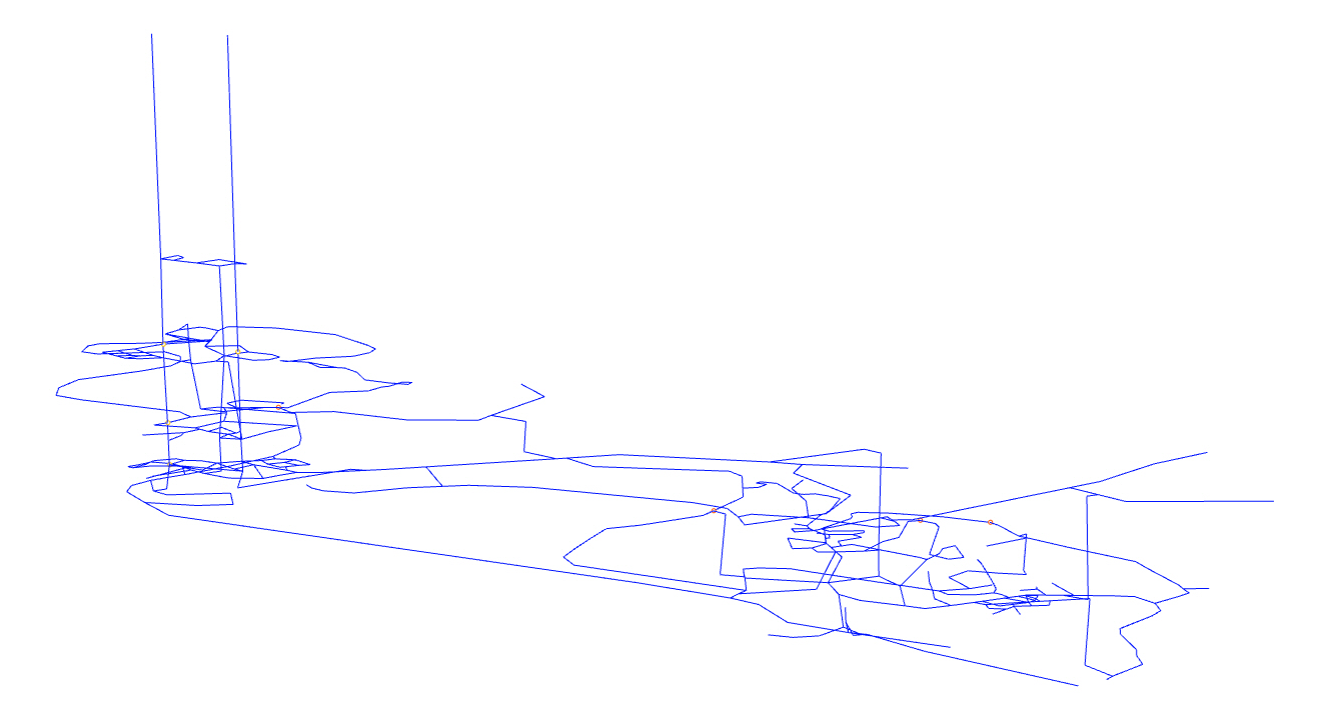

## Generate the data for the model.
The data required for the model is generated at this stage.

In [27]:
nodes_list = []
for node in range(len(nodes)):
    nodes_list.append(node)

In [28]:
arcs = []
for item1 in foot_time:
    arcs.append((item1[0], item1[1], item1[2]))

In [29]:
# Modes oftransport, 1 = vehicle, 2 = foot.
modes = [1, 2]

In [30]:
cost = {}
for item1 in vehicle_time:
        key = (item1[0], item1[1], item1[2], 1)
        value = item1[3]
        cost[key] = value
for item2 in foot_time:
        key = (item2[0], item2[1], item2[2], 2)
        value = item2[3]
        cost[key] = value

In [31]:
# Three routes are enumerated for the vehicles the mine.
# Two of the routes are located at the bottom half of the mine which is the active mining area.
# One route is located at the upper portion of the mine to cater for service crew, maintenace crew and engineers that may be performing surveys at the non-active areas.
routes = [0, 1, 2]

In [32]:
arcs_on_route_0 = [(127, 344, 1), (344, 150, 1), (150, 84, 1), (84, 110, 1), (110, 370, 1), (370, 288, 1)]
arcs_on_route_1 = [(253, 243, 1), (243, 409, 1), (409, 252, 1), (252, 271, 1), (271, 272, 1), (272, 303, 1), (303, 317, 1),
                   (317, 315, 1), (315, 304, 1), (304, 305, 1), (305, 306, 1), (306, 307, 1), (307, 308, 1), (308, 338, 1), 
                   (338, 389, 1), (389, 309, 1), (309, 388, 1), (388, 310, 1), (310, 311, 1), (311, 312, 1), (312, 197, 1)]
arcs_on_route_2 = [(130, 235, 1), (235, 92, 1), (92, 329, 1), (329, 289, 1), (289, 413, 1), (413, 330, 1), (330, 332, 1), 
                   (332, 423, 1), (423, 334, 1), (334, 302, 1), (302, 393, 1), (393, 103, 1)]

all_vehicle_arcs = arcs_on_route_0 + arcs_on_route_1 + arcs_on_route_2

### Visualize the vehicle routes.
The nodes along the three routes are shown in purple on the mine layout.

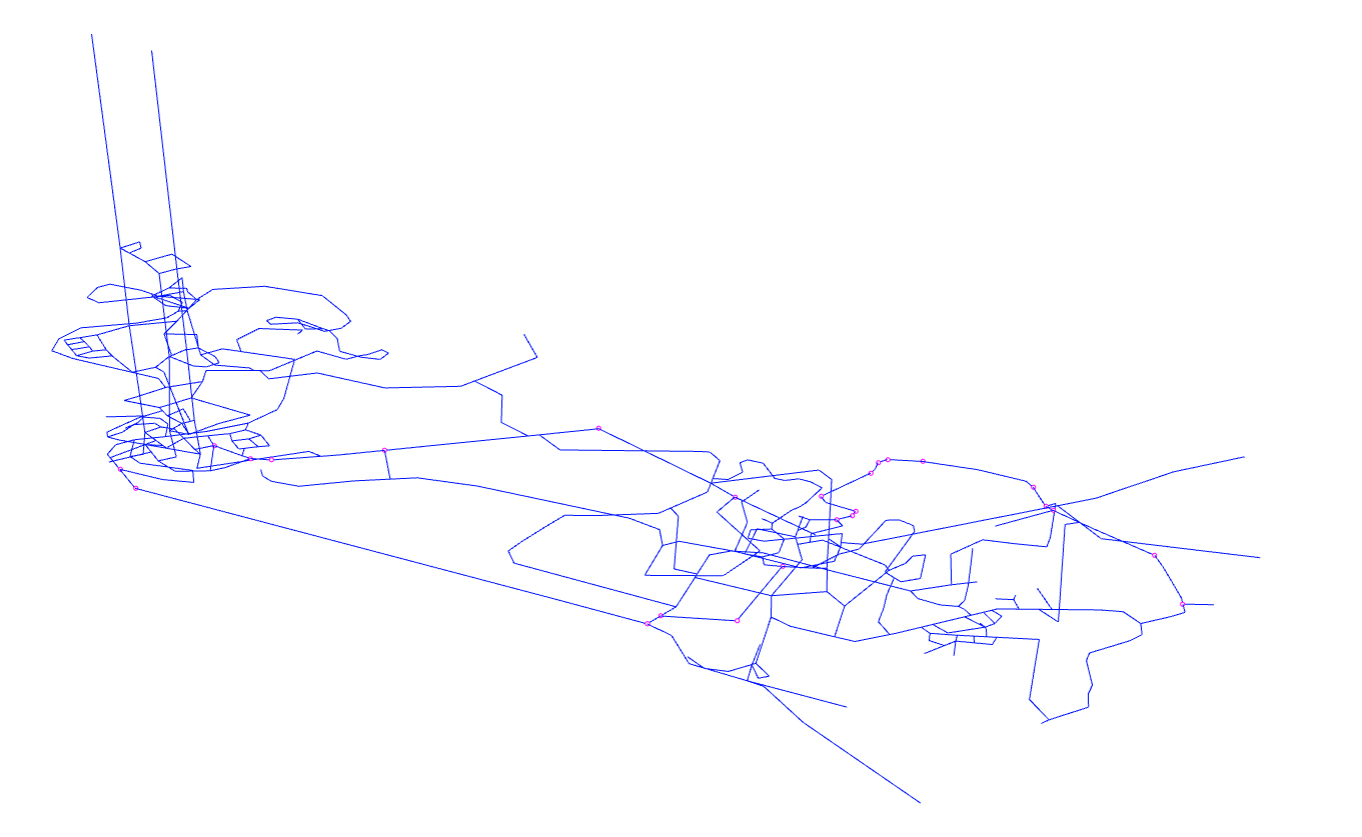

In [33]:
# The arc capacity was chosen to be 500 miners for all arcs. This is because, we are assumming that the drifts are wide enough to accommodate the movement of miners.
# This assumption is valid for most mines.
arc_capacity = {}
for arc in arcs:
    key = arc
    value = 500
    arc_capacity[key] = value

In [34]:
# The number of vehicles within the mine that are available to be used during the evacuation.
# This number was chosen with respect to the size of the mine and can be altered by the user.
va = 5

# The vehicle capacity is set equal assuming all vehicles are of the same type.
k = 4

### Set the net demand and capacities.
The net demand at each node is set here. Origin nodes, where miners are located, have a net demand of **-1**. The shafts have infinite capacity, so a value of **1000** is used. The refuge chambers have a capacity of **30** people each. This capacity was chosen in line with MineArc's Cost Effective Refuge-Chamber MineSAFE Essential Design specifications.

In [35]:
net_demand = {}
for node in nodes_list:
    if node in origins:
        net_demand[node] = -1
    elif node in shafts:
        net_demand[node] = 1000
    elif node in chambers:
        net_demand[node] = 30
    else:
        net_demand[node] = 0

## Construct the model.
The model is constructed at this stage. A concretemodel is defined for the TR Mine using the data collected. The **'gurobi'** solver was used to solve the model. Other solvers can be used by the user.

In [36]:
# Construct the model
model = pyo.ConcreteModel()

In [37]:
# Set up the solver
solver = SolverFactory('gurobi') 

In [38]:
# Sets
model.I = pyo.Set(initialize=origins)
model.J = pyo.Set(initialize=destinations)
model.N = pyo.Set(initialize=nodes_list)
model.M = pyo.Set(initialize=modes)
model.A = pyo.Set(initialize=arcs)
model.R = pyo.Set(initialize=routes)

In [39]:
# Parameters
model.u = pyo.Param(model.A, initialize=arc_capacity)
model.c = pyo.Param(model.A, model.M, initialize=cost)
model.netDemand = pyo.Param(model.N, initialize=net_demand)

In [40]:
# Decision variables
model.x = pyo.Var(model.A, model.M, domain=pyo.NonNegativeIntegers)
model.v = pyo.Var(model.R, domain=pyo.NonNegativeIntegers)

The objective function is as follows:

$$\min \sum_{i \in I}\sum_{j \in J}\sum_{m \in M} c_{ijm} \times x_{ijm}$$

The objective of the model is to minimize the total cost of transporting all the miners to the safe areas during evacuation using the modes of transportation available, in this case, using vehicles and walking.

In [41]:
# Construct the objective function
def objective_rule(model):
    return sum(model.c[i, j, s, m] * model.x[i, j, s, m] for (i, j, s) in model.A for m in model.M)
model.Obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

The net demand and capacity constraints are as follows:

$$\sum_{i \in I} \sum_{m \in M} x_{ikm} + s_k = d_k + \sum_{j \in J} \sum_{m \in M} x_{kjm} \; \forall k \in N$$

This constraint ensures the conservation of flow within the mine network. $s_k$ represents the supply at node k, and $d_k$ represents the demand at node k.

In [42]:
# Define the model constraints
# Net demand constraint
def net_demand_rule(model, i):
    if i in shafts or i in chambers:
        return (sum(model.x[k, i, s, m] for k in model.N for s in stam_indexes for m in model.M if (k, i, s) in model.A) - sum(model.x[i, j, s, m] for j in model.N for s in stam_indexes for m in model.M if (i, j, s) in model.A) <= model.netDemand[i])
    else:
        return (sum(model.x[k, i, s, m] for k in model.N for s in stam_indexes for m in model.M if (k, i, s) in model.A) - sum(model.x[i, j, s, m] for j in model.N for s in stam_indexes for m in model.M if (i, j, s) in model.A) == model.netDemand[i])
model.netDemandConstraints = pyo.Constraint(model.N, rule=net_demand_rule)

The vehicle capacity constraints are as follows:

$$x_{ij1} \le k \times v_r \; \; r \in R, (i, j) \in A_r$$

where $x_{ij1}$ is the number of people travesing arc (i, j) via vehicle, $k$ is the vehicle capacity, and $v_r$ is the number of vehicles traversing the route.

In [43]:
# Vehicle capacity constraints
model.vehicleConstraints = pyo.ConstraintList()
for r in routes:
    # Constraints for route 0
    if r == 0:
        for (i, j, s) in arcs_on_route_0:
            model.vehicleConstraints.add(model.x[i, j, s, 1] <= k * model.v[r])
    # Constraints for route 1
    if r == 1:
        for (i, j, s) in arcs_on_route_1:
            model.vehicleConstraints.add(model.x[i, j, s, 1] <= k * model.v[r])
    # Constraints for route 2
    else:
        for (i, j, s) in arcs_on_route_2:
            model.vehicleConstraints.add(model.x[i, j, s, 1] <= k * model.v[r])      

The vehicle capacity constraints are as follows:

$$k \times v_r + x_{ij2} \le u_{ij} \; \; \forall r \in R, (i, j) \in A_r$$

where $x_{ij2}$ is the number of people travesing arc (i, j) by foot, $u_{ij}$ is the route capacity, and $v_r$ is the number of vehicles traversing the route.

In [44]:
# Route capacity constraints
model.routeConstraints = pyo.ConstraintList()
for r in routes:
    # Constraints for route 0
    if r == 0:
        for (i, j, s) in arcs_on_route_0:
            model.routeConstraints.add(k * model.v[r] + model.x[i, j, s, 2] <= model.u[i, j, s])
    # Constraints for route 1
    if r == 1:
        for (i, j, s) in arcs_on_route_1:
            model.routeConstraints.add(k * model.v[r] + model.x[i, j, s, 2] <= model.u[i, j, s])
    # Constraints for route 2
    else:
        for (i, j, s) in arcs_on_route_2:
            model.routeConstraints.add(k * model.v[r] + model.x[i, j, s, 2] <= model.u[i, j, s]) 

In [45]:
# Constraint on available vehicles
def availability_rule(model):
    return sum(model.v[r] for r in model.R) <= va
model.availabilityConstraint = pyo.Constraint(rule=availability_rule)

In [46]:
# This constraint guarantees that a miner can only use a vehicle along an arc on which a vehicle can traverse.
model.con = pyo.ConstraintList()
for arc in arcs:
    if arc not in all_vehicle_arcs:
        con_lhs_expr = model.x[arc[0], arc[1], arc[2], 1] 
        con_rhs_expr = 0
        model.con.add(con_lhs_expr == con_rhs_expr)

## Solve the model.
The model is solved using the **gurobi** solver via Pyomo's Solverfactory.

In [47]:
result = solver.solve(model, tee=True)

Using license file C:\Users\fasare\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\fasare\AppData\Local\Temp\tmp0kvk7ka7.pyomo.lp
Reading time = 0.04 seconds
x6572: 4102 rows, 6572 columns, 16589 nonzeros
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 4102 rows, 6572 columns and 16589 nonzeros
Model fingerprint: 0x4223b9c2
Variable types: 1 continuous, 6571 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [6e-05, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 3687 rows and 5509 columns
Presolve time: 0.01s
Presolved: 415 rows, 1063 columns, 2327 nonzeros
Variable types: 0 continuous, 1063 integer (226 binary)

Root relaxation: objective 6.772074e+05, 749 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

In [48]:
stop = timeit.default_timer()
print('Time: ', stop - start) 

Time:  6.491122999927029


## Extract the optimal values.
The optimal values are extracted from the solved model and a table of results is shown below. The model was run for **three** differenct scenarios. The first scenario has **100** miners, which represent a night shift within the mine where the least number of people are underground. The second scenario has **200** miners, representing the average number of people underground during a regular morning shift at the mine. The final scenario has **300** people underground, representing a morning shift in which there are visitors at the mine such as college students.

In [49]:
# Check how many miners were sent to each safe zone

# shaft 28
# Number of miners arriving at shaft 28 via vehicle
shaft_28_v = []
for arc in model.A:
    if arc[1] == 28:
        shaft_28_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))
        
total_shaft_28_v = sum(shaft_28_v)

# Number of miners arriving at shaft 28 via foot
shaft_28_f = []
for arc in model.A:
    if arc[1] == 28:
        shaft_28_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_shaft_28_f = sum(shaft_28_f)


# shaft 69
# Number of miners arriving at shaft 69 via vehicle
shaft_69_v = []
for arc in model.A:
    if arc[1] == 69:
        shaft_69_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))

total_shaft_69_v = sum(shaft_69_v)

# Number of miners arriving at shaft 69 via foot
shaft_69_f = []
for arc in model.A:
    if arc[1] == 69:
        shaft_69_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_shaft_69_f = sum(shaft_69_f)


# shaft 73
# Number of miners arriving at shaft 73 via vehicle
shaft_73_v = []
for arc in model.A:
    if arc[1] == 73:
        shaft_73_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))

total_shaft_73_v = sum(shaft_73_v)

# Number of miners arriving at shaft 73 via foot
shaft_73_f = []
for arc in model.A:
    if arc[1] == 73:
        shaft_73_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_shaft_73_f = sum(shaft_73_f)


# shaft 74
# Number of miners arriving at shaft 74 via vehicle
shaft_74_v = []
for arc in model.A:
    if arc[1] == 74:
        shaft_74_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))

total_shaft_74_v = sum(shaft_74_v)


# Number of miners arriving at shaft 74 via foot
shaft_74_f = []
for arc in model.A:
    if arc[1] == 74:
        shaft_74_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_shaft_74_f = sum(shaft_74_f)

In [50]:
# Chamber 156
# Number of miners arriving at chamber 156 via vehicle
chamber_156_v = []
for arc in model.A:
    if arc[1] == 156:
        chamber_156_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))
        
total_chamber_156_v = sum(chamber_156_v)

# Number of miners arriving at chamber 156 via foot
chamber_156_f = []
for arc in model.A:
    if arc[1] == 156:
        chamber_156_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_chamber_156_f = sum(chamber_156_f)


# Chamber 198
# Number of miners arriving at chamber 198 via vehicle
chamber_198_v = []
for arc in model.A:
    if arc[1] == 198:
        chamber_198_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))
        
total_chamber_198_v = sum(chamber_198_v)

# Number of miners arriving at chamber 198 via foot
chamber_198_f = []
for arc in model.A:
    if arc[1] == 198:
        chamber_198_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_chamber_198_f = sum(chamber_198_f)


# Chamber 305
# Number of miners arriving at chamber 305 via vehicle
chamber_305_v = []
for arc in model.A:
    if arc[1] == 305:
        chamber_305_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))
        
total_chamber_305_v = sum(chamber_305_v)

# Number of miners arriving at chamber 305 via foot
chamber_305_f = []
for arc in model.A:
    if arc[1] == 305:
        chamber_305_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_chamber_305_f = sum(chamber_305_f)


# Chamber 348
# Number of miners arriving at chamber 348 via vehicle
chamber_348_v = []
for arc in model.A:
    if arc[1] == 348:
        chamber_348_v.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 1)]))
        
total_chamber_348_v = sum(chamber_348_v)

# Number of miners arriving at chamber 348 via foot
chamber_348_f = []
for arc in model.A:
    if arc[1] == 348:
        chamber_348_f.append(pyo.value(model.x[(arc[0], arc[1], arc[2], 2)]))
        
total_chamber_348_f = sum(chamber_348_f)

In [51]:
# model.v.pprint()